# 6. Authentication based on user movements and traffic

In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt

import sys  
sys.path.insert(1, '../src/')

from train_model import ClassifierEvaluator
from train_auth import AuthenticationEvaluator
from visualize import VisualizationUtils
import seaborn as sns
# import shap for ai explainability
import shap

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import tree

# import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

In [2]:
mov_slow = pd.read_csv('../data/processed/movement_slow_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
mov_fast = pd.read_csv('../data/processed/movement_fast_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
traffic_slow = pd.read_csv('../data/processed/traffic_slow_stat_cleaned.csv', index_col=0).fillna(0)
traffic_fast = pd.read_csv('../data/processed/traffic_fast_stat_cleaned.csv', index_col=0).fillna(0)

# # Drop height
# for col in mov_fast.columns.values:
#     if "PosY" in col and "Accel" not in col and "Velocity" not in col:
#         print(col)
#         for id in range(60):
#             #print(id, col, mov_fast.loc[mov_fast['ID'] == id][col])
#             print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
#             mov_fast.loc[mov_fast['ID'] == id,col] = mov_fast.loc[mov_fast['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])
#             print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
#             mov_slow.loc[mov_slow['ID'] == id,col] = mov_slow.loc[mov_slow['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])

# Concatenate movement and traffic data for both slow and fast datasets
slow_combined = pd.concat([mov_slow, traffic_slow.drop(columns=['time_interval','ID'])], axis=1).dropna()
fast_combined = pd.concat([mov_fast, traffic_fast.drop(columns=['time_interval','ID'])], axis=1).dropna()
unique_minutes = list(range(1,11))

### 6.1. Training On Beat Saber

In [3]:
evaluator = AuthenticationEvaluator()


In [4]:
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(slow_combined, fast_combined, id_range=range(0,30), train_minutes=8, test_minutes=2)
Accuracy_set, models = evaluator.evaluate_authenticators(30,fX_train,fy_train,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Test)').style.background_gradient(cmap= plt.cm.Blues)
    

Size of the training set:  (1437, 490)
Size of the slow testing set:  (360, 490)
Size of the fast training set:  (1440, 490)
Size of the fast testing set:  (360, 490)


100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:24<00:00, 51.01s/it]


,Model,Accuracy(Train),Accuracy(Test),Precision(Train),Precision(Test),Precisions(Train),Precisions(Test),Accuracies(Train),Accuracies(Test),Recall(Train),Recall(Test),Recalls(Train),Recalls (Test),Recalls(Test)
2,LGBMClassifier,1.000000,0.991759,1.000000,0.948992,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.8817335402349812, 1.0, 0.9971428571428571, 0.8817663817663818, 0.998567335243553, 1.0, 1.0, 0.8247863247863247, 1.0, 1.0, 0.9943181818181819, 0.809593023255814, 1.0, 0.804093567251462, 1.0, 0.819327731092437, 1.0, 0.9615384615384616, 0.875, 0.9860335195530726, 0.9285714285714286, 0.9568965517241379, 0.9615384615384616, 1.0, 0.9929178470254958, 0.9216360008867213, 0.9457142857142857, 1.0, 0.9285714285714286, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.9861111111111112, 1.0, 0.9944444444444445, 0.9805555555555555, 0.9972222222222222, 1.0, 1.0, 0.975, 1.0, 1.0, 0.9888888888888889, 0.9777777777777777, 1.0, 0.9777777777777777, 1.0, 0.9694444444444444, 1.0, 0.9972222222222222, 0.9888888888888889, 0.9722222222222222, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 1.0, 0.9861111111111112, 0.9916666666666667, 0.9888888888888889, 1.0, 0.9944444444444445, 1.0]",1.000000,0.924665,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",nan,"[0.9123563218390804, 1.0, 0.9166666666666667, 0.7887931034482758, 0.9583333333333333, 1.0, 1.0, 0.7456896551724138, 1.0, 1.0, 0.8333333333333333, 0.9080459770114943, 1.0, 0.9482758620689655, 1.0, 0.5818965517241379, 1.0, 0.9985632183908046, 0.9942528735632183, 0.5833333333333334, 0.9971264367816092, 0.9568965517241379, 0.9985632183908046, 1.0, 0.7916666666666667, 0.9554597701149425, 0.8735632183908046, 1.0, 0.9971264367816092, 1.0]"
0,ExtraTreesClassifier,1.000000,0.993889,1.000000,0.996895,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.9929178470254958, 1.0, 1.0, 0.9929178470254958, 0.9971428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998567335243553, 1.0, 0.9860335195530726, 0.9915254237288136, 0.9860335195530726, 1.0, 0.998567335243553, 1.0, 0.9901408450704225, 0.9943181818181819, 1.0, 1.0, 1.0, 0.9957264957264957, 1.0, 0.9929178470254958, 1.0, 0.9943181818181819, 0.9957264957264957]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.9861111111111112, 1.0, 1.0, 0.9861111111111112, 0.9944444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9722222222222222, 0.9833333333333333, 0.9722222222222222, 1.0, 0.9972222222222222, 1.0, 0.9805555555555555, 0.9888888888888889, 1.0, 1.0, 1.0, 0.9916666666666667, 1.0, 0.9861111111111112, 1.0, 0.9888888888888889, 0.9916666666666667]",1.000000,0.908333,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",nan,"[0.7916666666666667, 1.0, 1.0, 0.7916666666666667, 0.9166666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9583333333333333, 1.0, 0.5833333333333334, 0.75, 0.5833333333333334, 1.0, 0.9583333333333333, 1.0, 0.7083333333333334, 0.8333333333333333, 1.0, 1.0, 1.0, 0.875, 1.0, 0.7916666666666667, 1.0, 0.8333333333333333, 0.875]"
1,RandomForestClassifier,1.000000,0.994444,1.000000,0.980522,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9915254237288136, 1.0, 1.0, 1.0, 0.998567335243553, 1.0, 0.9887640449438202, 0.9901408450704225, 0.48333333333333334, 1.0, 0.99714

[0.99558915 0.99606481 0.99611111 0.99666667 0.99555556 0.99555556] [300. 102.  52.  27.  26.  26.] [10440.  3480.  1740.   870.   870.   870.] [0. 0. 0. 0. 0. 0.] [60. 18.  8.  3.  4.  4.]


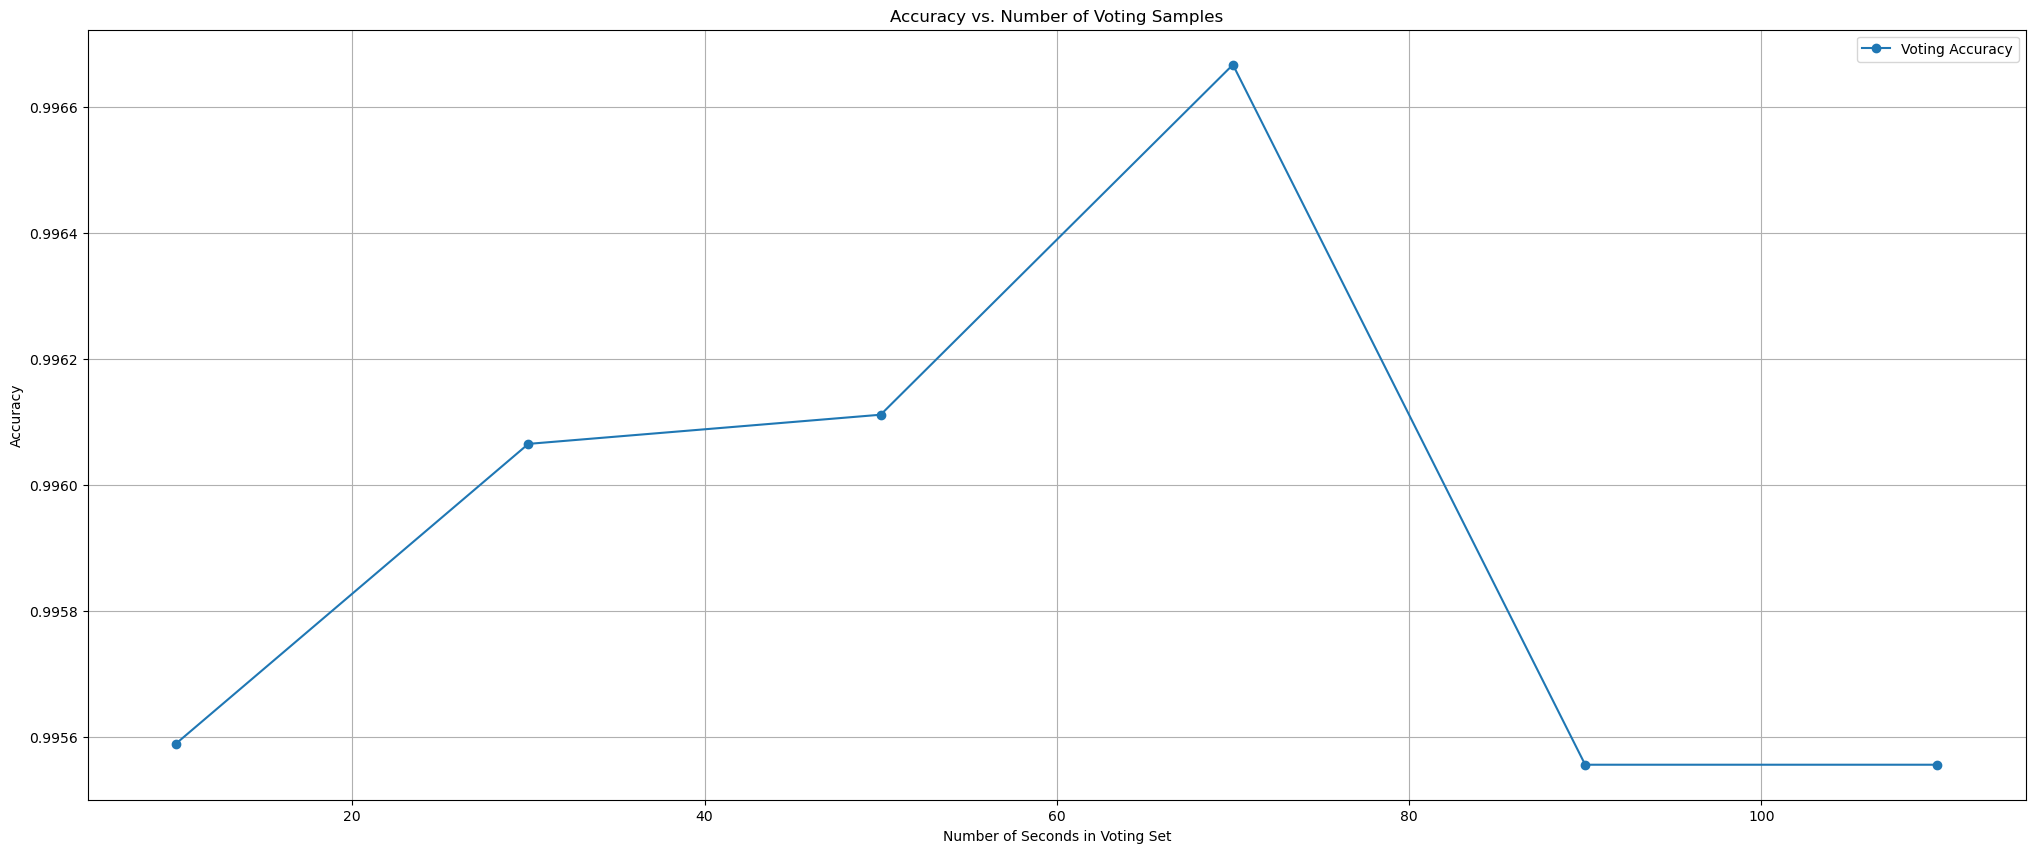

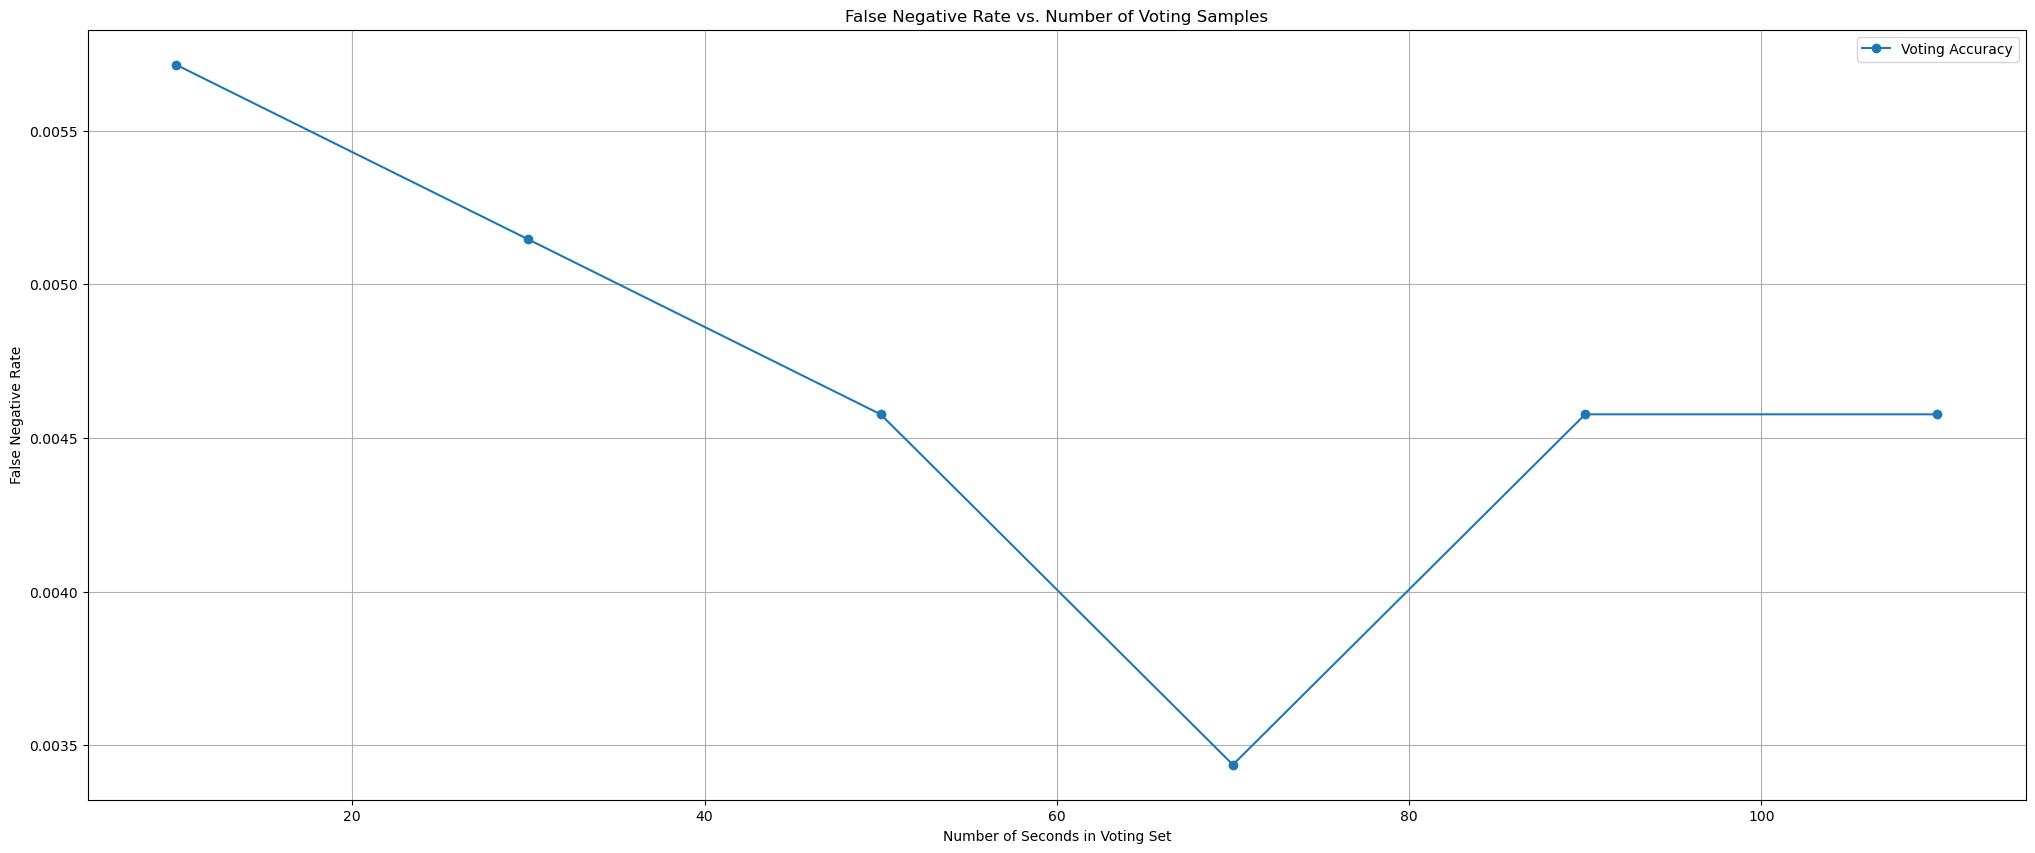


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.995589
1,30,0.996065
2,50,0.996111
3,70,0.996667
4,90,0.995556
5,110,0.995556


In [5]:
evaluator.plot_accuracy_by_vote(models, fX_test, fy_test, increment=2)

In [ ]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

In [ ]:
# Find the participant with the highest misclassification
misclassified_participant = np.argmax(np.sum(cm_slow, axis=1) - np.diag(cm_slow))
confused_with = np.argmax(cm_slow[misclassified_participant, :])
print(f"Participant {misclassified_participant} is most often misclassified as {confused_with}")

In [ ]:
# Compare features between the misclassified participant and the one they're confused with
features_to_compare = [col for col in mov_slow.columns if col != 'ID']
misclassified_data = mov_slow[mov_slow['ID'] == misclassified_participant][features_to_compare]
confused_with_data = mov_slow[mov_slow['ID'] == confused_with][features_to_compare]

In [ ]:
# Calculate feature similarities
similarities = 1 - np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())

# Sort features by similarity
most_similar_features = similarities.sort_values(ascending=False)

In [ ]:
print("\nTop 10 most similar features:")
print(most_similar_features.head(10))

In [ ]:
# Visualize feature distributions for top 5 similar features
top_5_features = most_similar_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Analyze differences in other features
differences = np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())
most_different_features = differences.sort_values(ascending=False)

print("\nTop 10 most different features:")
print(most_different_features.head(10))

In [ ]:
# Visualize feature distributions for top 5 different features
top_5_different_features = most_different_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_different_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

In [ ]:
evaluator.accuracy_over_ids(X_train, y_train, best_model_slow_name,  X_test, y_test,fX_test, fy_test)

### 4.2. Training On Beat Saber

In [ ]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast,  best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

In [ ]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

In [ ]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Beat Saber)",
                          class_names=['Beat Saber'])

In [ ]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

In [ ]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

In [ ]:
evaluator.accuracy_over_time(fX, fy, best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

In [ ]:
evaluator.accuracy_over_ids(fX_train, fy_train, best_model_fast_name, X_test, y_test,fX_test, fy_test)

### 4.3. Training On Forklift Simulator

In [ ]:
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(mov_slow, mov_fast, id_range=range(30,60), train_minutes=8, test_minutes=2)

In [ ]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

In [ ]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)

In [ ]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow, axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (ForkLift Simulator)",
                          class_names=['ForkLift Simulator'])

In [ ]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

In [ ]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

In [ ]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

In [ ]:
evaluator.accuracy_over_ids(X_train, y_train,best_model_slow_name, X_test, y_test,fX_test, fy_test)

### 4.4. Training On Medal of Honor

In [ ]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

In [ ]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

In [ ]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Medal Of Honor)",
                          class_names=['Medal Of Honor'])

In [ ]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

In [ ]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

In [ ]:
evaluator.accuracy_over_time(fX, fy,best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

In [ ]:
evaluator.accuracy_over_ids(fX_train, fy_train,best_model_fast_name, X_test, y_test,fX_test, fy_test)